In [2]:
import numpy as np
import pprint
import mne
import pyxdf
import matplotlib.pyplot as plt
from pathlib import Path

from scipy import signal

import util.preprocess_util as preprocess
import util.analysis_util as analysis
import util.visualise_util as visualise
from util.data_util import EEG_Dataset, get_trials, get_good_trials
from models.lda import *

%load_ext autoreload
%autoreload 2

# Load data from xdf file

From the Unicorn Stream
- `eeg_data`: the 8 channel raw eeg data
- `eeg_timestamps`: timestamp for each eeg sample
- `fs`: the sampling frequency

From the Open Vibe Marker Stream
- `event_codes`: array of codes sent to the marker stream at the start of each event 
- `event_time_stamps`: array of timestamps signifying the start of each event


In [3]:
DATA_DIR = Path('./data')
DATA_FILE_NAME = 'Sandra_MI_1h.xdf'
DATA_FILE = DATA_DIR / DATA_FILE_NAME

dataset = EEG_Dataset(DATA_FILE)

Data succesfullly loaded from data/Sandra_MI_1h.xdf


In [4]:
# Extract the EEG data
eeg_data = dataset.eeg_data
eeg_timestamps = dataset.eeg_timestamps
fs = dataset.fs

print(f"EEG data shape: {eeg_data.shape}")
print(f'Sampling Frequency: {fs}')

# Extract the marker stream data
event_codes = dataset.event_codes
event_labels = dataset.event_labels
label2code = dataset.label2code
print(f'Total number of events: {event_codes.shape[0]}')
pprint.pprint(f'Label->Code: \n{label2code}')
print(f'Event code for left MI: {label2code["imagery_handL"]}')
print(f'Event code for right MI: {label2code["imagery_handR"]}')
print(f'Count left MI events: {np.sum(event_codes == label2code["imagery_handL"])}')
print(f'Count right MI events: {np.sum(event_codes == label2code["imagery_handR"])}')

EEG data shape: (8, 1023780)
Sampling Frequency: 250
Total number of events: 1213
('Label->Code: \n'
 "{'beep': 0, 'cue_no_blink': 1, 'imagery_no_blink': 2, 'break': 3, "
 "'cue_handR': 4, 'imagery_handR': 5, 'cue_handL': 6, 'imagery_handL': 7}")
Event code for left MI: 7
Event code for right MI: 5
Count left MI events: 200
Count right MI events: 200


# Build an event time-series/stream

Create a time series from the event codes which is the same length as the EEG data

In [5]:
eeg_timestamps, event_timestamps, event_timeseries = dataset.build_event_timeseries()

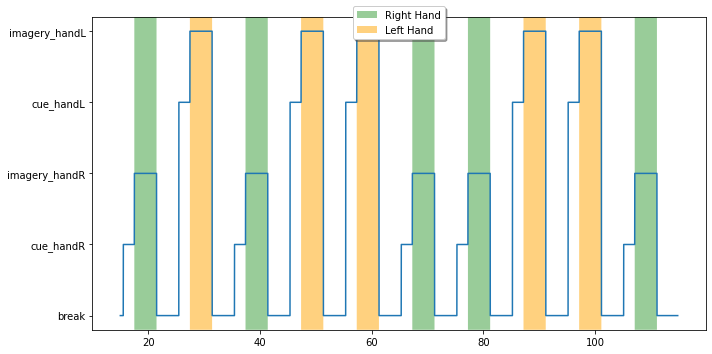

In [6]:
visualise.plot_events(
    eeg_timestamps,
    event_timeseries,
    fs,
    label2code
)

# Preprocess EEG data

## 1. Rereference the EEG data

In [7]:
# Rereference according to the mean
eeg_data = eeg_data - np.mean(eeg_data, axis=0)

## 2. Filter EEG data

In [8]:
lf = 8
hf = 16
nf = 50

# Design notch filter
b, a = signal.iirnotch(w0=nf, Q=7, fs=fs)
freq, h = signal.freqz(b, a, fs = fs)

# Apply notch and bandpass filters
eeg_notched = signal.filtfilt(b, a, eeg_data, axis=1)
eeg_notched_bp = preprocess.bandpass(eeg_notched, lf=lf, hf=hf, fs=fs, ftype='butter')

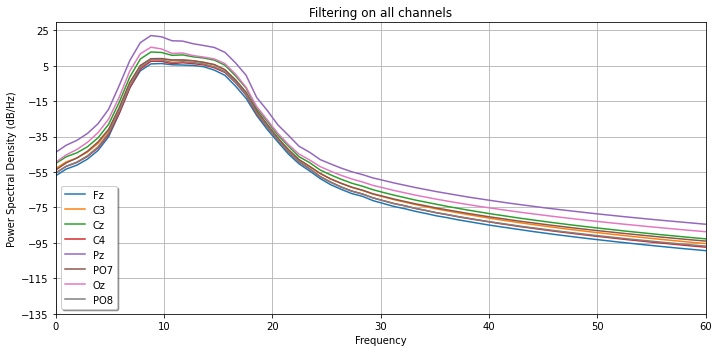

In [9]:
plt.figure(figsize=(10,5))
plt.title(f'Filtering on all channels')

for i in range(eeg_data.shape[0]):
    plt.psd(eeg_notched_bp[i], Fs=fs, label=f'{preprocess.channel2name(i)}')

plt.tight_layout()
plt.legend(loc='lower left', shadow=True)
plt.xlim([0,60])
plt.show()

## 3. Normalise EEG data

In [10]:
eeg_notched_bp_norm = preprocess.normalise_eeg(eeg_notched_bp)

# Inspect EEG data with markers

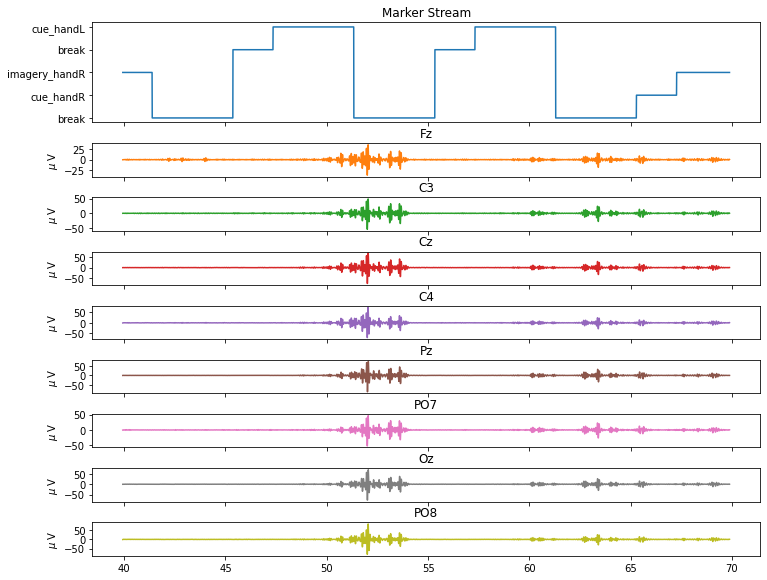

In [11]:
visualise.plot_all(
    eeg_timestamps=eeg_timestamps, 
    event_time_series=event_timeseries, 
    eeg_data=eeg_notched_bp_norm, 
    event_labels=event_labels,
    fs=fs,
    start_time=40
)

# Split into trials

In [12]:
EEG = eeg_notched_bp_norm.copy()
event_onsets = event_timestamps.copy()
classes = ['imagery_handL', 'imagery_handR']
class_codes = [label2code[code] for code in classes]
nclasses = len(classes)
nchannels = EEG.shape[0]

# Print some information
print('Sample rate:', fs)
print('Number of EEG channels:', nchannels)
print('Channel names:', [preprocess.channel2name(channel) for channel in range(EEG.shape[0])])

print('\nNumber of classes:', nclasses)
print('Class labels:', classes)

print('\nNumber of events:', len(event_onsets))
print('All event codes:', np.unique(event_codes))
print('Class codes:', class_codes)

Sample rate: 250
Number of EEG channels: 8
Channel names: ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'PO7', 'Oz', 'PO8']

Number of classes: 2
Class labels: ['imagery_handL', 'imagery_handR']

Number of events: 1213
All event codes: [0 1 2 3 4 5 6 7]
Class codes: [7, 5]


In [13]:
mi_window = [0.5, 2.5]
mi_nsamples = len(np.arange(int(mi_window[0]*fs), int(mi_window[1]*fs)))

idle_window = [0.25, 1.75]
idle_nsamples = len(np.arange(int(idle_window[0]*fs), int(idle_window[1]*fs)))

class_nsamples = [mi_nsamples, mi_nsamples]

trials = get_trials(
    eeg_data=EEG,
    event_time_series=event_timeseries,
    class_labels=classes,
    label2code=label2code,
    nsamples=class_nsamples
)

for key, val in trials.items():
    print(f'{key}: {val.shape}')

imagery_handL: (8, 500, 200)
imagery_handR: (8, 500, 200)


# Some statistical Analysis to remove noisy trials

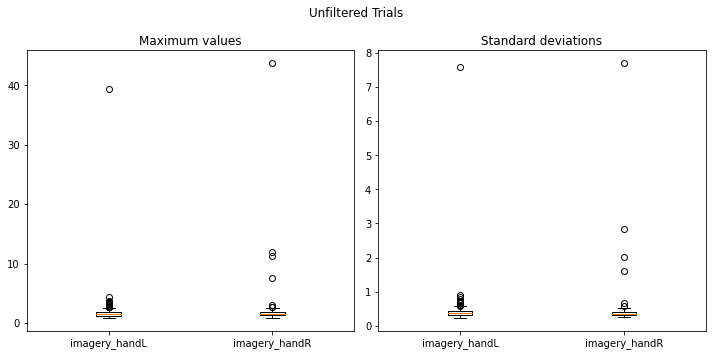

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Unfiltered Trials')

axs[0].set_title('Maximum values')
axs[0].boxplot([ trials[cl].max(axis = (0,1)) for cl in classes ], labels=classes)

axs[1].set_title('Standard deviations')
axs[1].boxplot([ trials[cl].std(axis = (0,1)) for cl in classes ], labels=classes)

plt.tight_layout()
plt.show()

In [15]:
# Set the upper limit on the maxval and std dev as 2*(3rd quartile)

upperlimit_max = {}
for cl in classes:
    upperlimit_max[cl] = np.percentile(trials[cl].max(axis = (0,1)), [75])[0] * 1.5

upperlimit_std = {}
for cl in classes:
    upperlimit_std[cl] = np.percentile(trials[cl].std(axis = (0,1)), [75])[0] * 1.5

upperlimit_std

{'imagery_handL': 0.6426090228435588, 'imagery_handR': 0.6286240632254274}

In [16]:
good_trials = get_good_trials(
    trials=trials,
    nchannels=nchannels,
    class_nsamples=class_nsamples,
    upperlimit_std=upperlimit_std,
    upperlimit_max=upperlimit_max
)

for cl in classes:
    print(f'{cl} has {good_trials[cl].shape} non noisy trials')


imagery_handL has (8, 500, 187) non noisy trials
imagery_handR has (8, 500, 194) non noisy trials


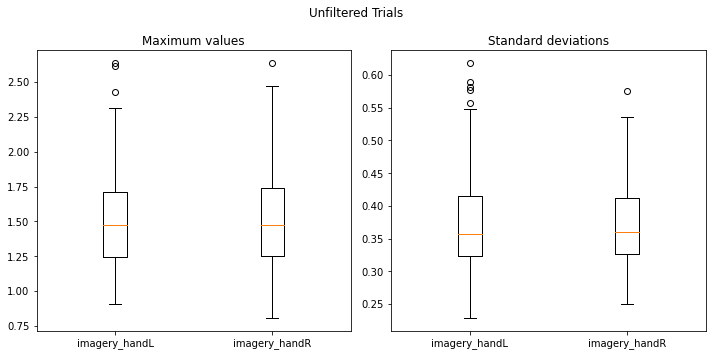

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Unfiltered Trials')

axs[0].set_title('Maximum values')
axs[0].boxplot([ good_trials[cl].max(axis = (0,1)) for cl in classes ], labels=classes)

axs[1].set_title('Standard deviations')
axs[1].boxplot([ good_trials[cl].std(axis = (0,1)) for cl in classes ], labels=classes)

plt.tight_layout()
plt.show()

# Analysis

In [18]:
# Print some information
print('Shape of EEG:', EEG.shape)
print('Sample rate:', fs)
print('Number of channels:', EEG.shape[0])
print('Channel names:', [preprocess.channel2name(channel) for channel in range(EEG.shape[0])])
print('Number of events:', len(event_onsets))
print('Event codes:', np.unique(event_codes))
print('Class labels:', classes)
print('Class codes:', class_codes)
print('Number of classes:', nclasses)

cl0 = classes[0]
cl1 = classes[1]

Shape of EEG: (8, 1023780)
Sample rate: 250
Number of channels: 8
Channel names: ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'PO7', 'Oz', 'PO8']
Number of events: 1213
Event codes: [0 1 2 3 4 5 6 7]
Class labels: ['imagery_handL', 'imagery_handR']
Class codes: [7, 5]
Number of classes: 2


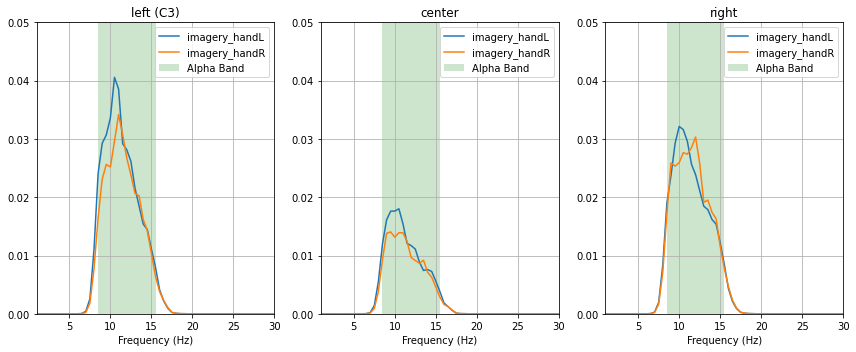

In [19]:
trials_PSD = {}
for cl in classes:
    psd, freqs, = analysis.psd(good_trials[cl], nchannels, class_nsamples[0], fs)
    trials_PSD[cl] = psd

analysis.plot_psd(
    trials_PSD,
    freqs,
    [preprocess.name2channel(name) for name in ['C3', 'Cz', 'C4']],
    chan_lab=['left (C3)', 'center', 'right'],
    maxy=0.05   #0.05 for normalised data and 1 for not normalised
)

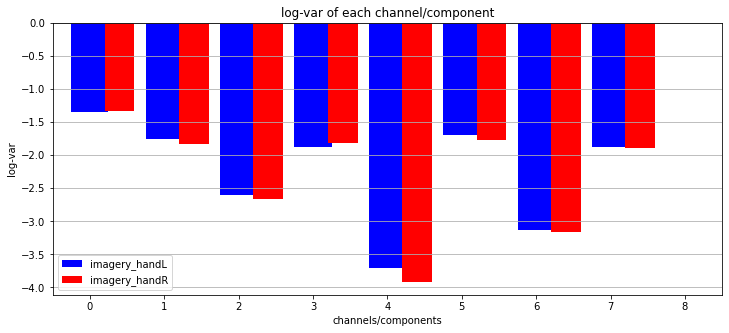

In [20]:
trials_logvar = {}
for cl in classes:
    trials_logvar[cl] = analysis.logvar(good_trials[cl])

analysis.plot_logvar(trials_logvar, classes)

### CSP
Using CSP generates components which are easier to classify than the channels. 

Instead of 8 channels, we now have 8 mixtures of channels, called components. They are the result of 8 spatial filters applied to the data.

The first filters maximize the variation of the first class, while minimizing the variation of the second. The last filters maximize the variation of the second class, while minimizing the variation of the first.

This is also visible in a PSD plot.

Shape for class imagery_handL after csp: (8, 500, 187)
Shape for class imagery_handR after csp: (8, 500, 194)
Shape for class imagery_handL after logvar: (8, 187)
Shape for class imagery_handR after logvar: (8, 194)


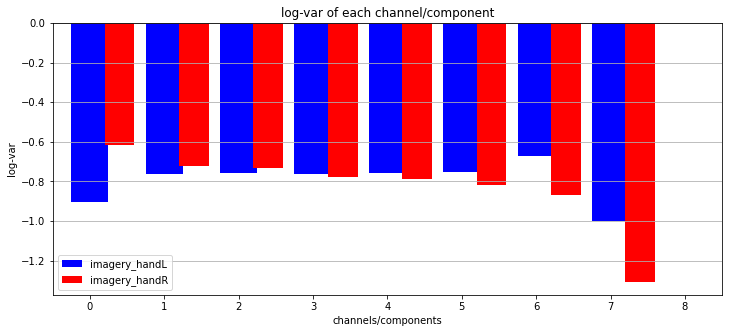

In [21]:
csp = preprocess.CSP(good_trials, classes, class_nsamples[0], nchannels)
trials_csp = csp.get_csp_trials()

for cl in classes:
    print(f'Shape for class {cl} after csp: {trials_csp[cl].shape}')

trials_csp_logvar = {}
for cl in classes:
    trials_csp_logvar[cl] = analysis.logvar(trials_csp[cl])
    print(f'Shape for class {cl} after logvar: {trials_csp_logvar[cl].shape}')

analysis.plot_logvar(trials_csp_logvar, classes)

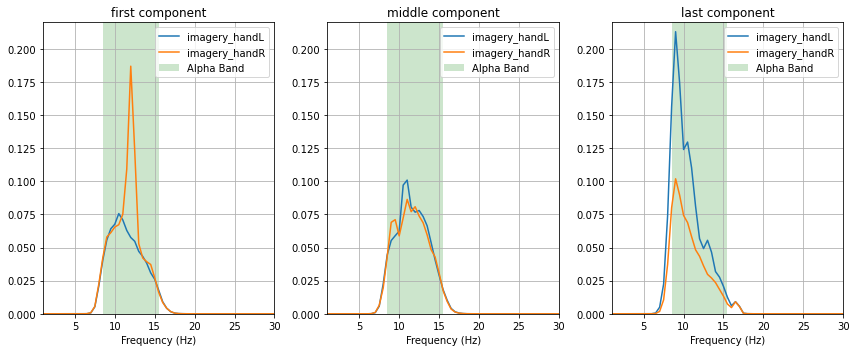

In [22]:
trials_PSD = {}
for cl in classes:
    psd, freqs, = analysis.psd(trials_csp[cl], nchannels, class_nsamples[0], fs)
    trials_PSD[cl] = psd

analysis.plot_psd(
    trials_PSD,
    freqs,
    [0,3,-1],
    chan_lab=['first component', 'middle component', 'last component'],
    maxy=0.22
)

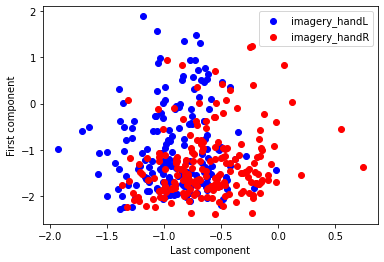

In [23]:
analysis.plot_scatter(trials_csp_logvar[cl0], trials_csp_logvar[cl1], classes)

## LDA

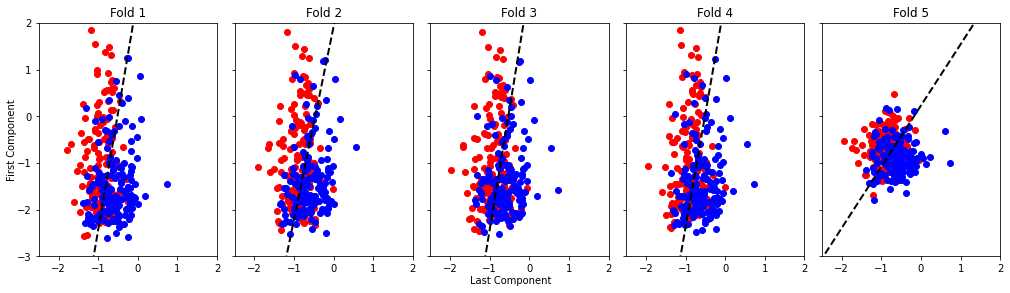

In [24]:
# H-PARAMS
nfolds = 5                              # Number of folds
components = np.array([0,-1])           # Select components as features for classification


# Find size of cross val datasets
test_set_shapes = {}
train_set_shapes = {}
for cl in classes:
    test_set_shapes[cl] = int(good_trials[cl].shape[2] / nfolds)
    train_set_shapes[cl] = good_trials[cl].shape[2] - test_set_shapes[cl]


# Places to plot/view the results
fig, axs = plt.subplots(1,5, figsize=(14,4), sharex=True, sharey=True)
fig.text(0.5, 0.001, 'Last Component', ha='center')
fig.text(0.001, 0.5, 'First Component', va='center', rotation='vertical')
accuracies = {}
confusion_matrices = {}

# Run cross validation for k folds
for i in range(nfolds):    
    train = {}
    test = {}
    for cl in classes:
        ntest = test_set_shapes[cl]
        train[cl] = np.concatenate(
            [good_trials[cl][:,:,:i*ntest], 
            good_trials[cl][:,:,(i+1)*ntest:]], axis=2)
        
        test[cl] = good_trials[cl][:,:,i*ntest:(i+1)*ntest]
        # print(f'{cl} train shape: {train[cl].shape}')
        # print(f'{cl} test shape: {test[cl].shape}')

    # CSP
    train_csp = preprocess.CSP(train, classes, class_nsamples[0], nchannels)
    train = train_csp.get_csp_trials()
    W = train_csp.get_W()

    test_csp = preprocess.CSP(test, classes, class_nsamples[0], nchannels, W=W)
    test = test_csp.get_csp_trials()

    for cl in classes:
        train[cl] = train[cl][components,:,:]
        test[cl] = test[cl][components,:,:]
        # print(f'CSP ({cl}) train: {train[cl].shape}, test: {test[cl].shape}')

    # Logvar
    for cl in classes:
        train[cl] = analysis.logvar(train[cl])
        test[cl] = analysis.logvar(test[cl])
        # print(f'Logvar ({cl}) train: {train[cl].shape}, test: {test[cl].shape}')


    # Train LDA
    W,b = train_lda(train[cl0].T, train[cl1].T)

    # Scatterplot 
    for cl, col in zip(classes, ['r', 'b']):
        axs[i].scatter(train[cl][0,:], train[cl][-1,:], color=col)
    # Calculate decision boundary (x,y)
    x = np.arange(-3, 2, 0.1)
    y = (b - W[0]*x) / W[1]
    # Plot the decision boundary
    axs[i].plot(x,y, linestyle='--', linewidth=2, color='k')
    axs[i].set_xlim(-2.5, 2)
    axs[i].set_ylim(-3, 2)
    axs[i].set_title(f'Fold {i+1}')


    # Print confusion matrix
    conf = np.array([
        [(apply_lda(test[cl0], W, b) == 1).sum(), 
        (apply_lda(test[cl1], W, b) == 1).sum()],
        [(apply_lda(test[cl0], W, b) == 2).sum(), 
        (apply_lda(test[cl1], W, b) == 2).sum()],
    ])

    confusion_matrices[i] = conf
    accuracies[i] = np.sum(np.diag(conf)) / float(np.sum(conf))


plt.tight_layout()
plt.show()

In [25]:
visualise.print_results(classes, accuracies, confusion_matrices)

Accuracy	True imagery_handL	False imagery_handL	False imagery_handR	True imagery_handR
--------------------------------------------------------------------------------------------------------------
0.57			20			15			17			23
0.68			21			8			16			30
0.56			25			21			12			17
0.65			26			15			11			23
0.75			22			4			15			34
--------------------------------------------------------------------------------------------------------------
0.64			22.8			12.6			14.2			25.4
--------------------------------------------------------------------------------------------------------------


In [26]:
visualise.print_results(classes, accuracies, confusion_matrices, format='md')

Fold |Accuracy	| True imagery_handL	| False imagery_handL	| False imagery_handR	| True imagery_handR |
--- |--- |--- |--- |--- |--- |
Fold 0 | 0.57		| 20		| 15		| 17		| 23 |
Fold 1 | 0.68		| 21		| 8		| 16		| 30 |
Fold 2 | 0.56		| 25		| 21		| 12		| 17 |
Fold 3 | 0.65		| 26		| 15		| 11		| 23 |
Fold 4 | 0.75		| 22		| 4		| 15		| 34 |
Average |0.64		| 22.8		| 12.6		| 14.2		| 25.4 |
